iter 500 | loss=0.6921 | bit-acc=0.521
a=236133877  b=976600362  true=1212734239  pred=1955004414  ok=False
------------------------------------------------------------
iter 1000 | loss=0.6897 | bit-acc=0.542
a=558908130  b=82446307  true=641354437  pred=112263118  ok=False
------------------------------------------------------------
iter 1500 | loss=0.6379 | bit-acc=0.745
a=94504340  b=1646290193  true=1740794533  pred=25321605  ok=False
------------------------------------------------------------
iter 2000 | loss=0.0448 | bit-acc=1.000
a=1070137103  b=193319915  true=1263457018  pred=1263457018  ok=True
------------------------------------------------------------
iter 2500 | loss=0.0142 | bit-acc=1.000
a=183903945  b=2090862107  true=2274766052  pred=2274766052  ok=True
------------------------------------------------------------
iter 3000 | loss=0.0077 | bit-acc=1.000
a=340159974  b=1144492818  true=1484652792  pred=1484652792  ok=True
-----------------------------------------------

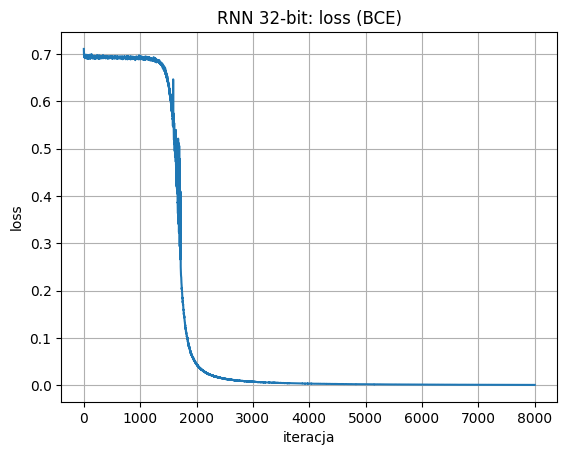

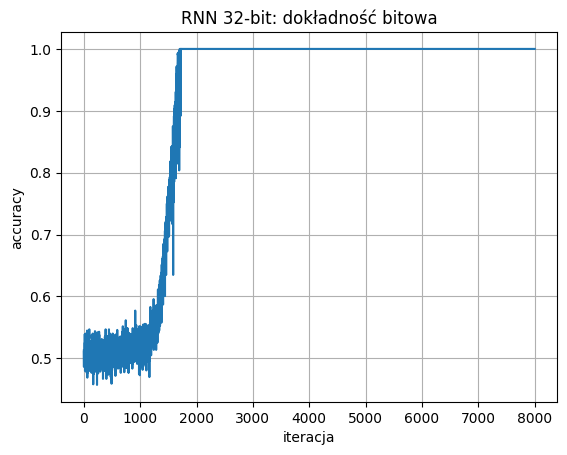

TEST 0: 1222529569 + 1814931942 = 3037461511 | pred=3037461511 | ok=True
TEST 1: 1397937206 + 1576366678 = 2974303884 | pred=2974303884 | ok=True
TEST 2: 870291629 + 2009140019 = 2879431648 | pred=2879431648 | ok=True
TEST 3: 245717356 + 154953448 = 400670804 | pred=400670804 | ok=True
TEST 4: 1915241754 + 203588170 = 2118829924 | pred=2118829924 | ok=True


In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

N_BITS = 32

def int_to_bits(x, n_bits=N_BITS):
    return np.array(list(np.binary_repr(x, width=n_bits))).astype(np.int8)

def bits_to_int(bits):
    return int("".join(bits.astype(str)), 2)

def sigmoid(z):
    z = np.clip(z, -50, 50)
    return 1.0 / (1.0 + np.exp(-z))

def dsigmoid(y):
    return y * (1 - y)

def tanh(z):
    return np.tanh(z)

def dtanh(h):
    return 1 - h**2

class RNNAdder:
    def __init__(self, hidden_size=128, lr=0.1, clip=1.0):
        self.H = hidden_size
        self.lr = lr
        self.clip = clip

        self.Wxh = np.random.randn(2, self.H) * 0.1
        self.Whh = np.random.randn(self.H, self.H) * 0.1
        self.Why = np.random.randn(self.H, 1) * 0.1

        self.bh = np.zeros((1, self.H))
        self.by = np.zeros((1, 1))

    def forward(self, X):
        """
        X: (B, T, 2) gdzie T=32
        Zwraca: hs (B, T+1, H), ys (B, T, 1)
        """
        B, T, _ = X.shape
        hs = np.zeros((B, T+1, self.H))
        ys = np.zeros((B, T, 1))

        for t in range(T):
            x_t = X[:, t, :]  # (B,2)
            hs[:, t+1, :] = tanh(x_t @ self.Wxh + hs[:, t, :] @ self.Whh + self.bh)
            ys[:, t, :] = sigmoid(hs[:, t+1, :] @ self.Why + self.by)

        return hs, ys

    def loss_bce(self, Y_pred, Y_true):
        """
        BCE po wszystkich bitach i batchu
        Y_pred, Y_true: (B, T, 1)
        """
        eps = 1e-8
        Y_pred = np.clip(Y_pred, eps, 1-eps)
        return -np.mean(Y_true*np.log(Y_pred) + (1-Y_true)*np.log(1-Y_pred))

    def backward(self, X, Y_true, hs, ys):
        """
        BPTT pełne po 32 krokach.
        """
        B, T, _ = X.shape

        dWxh = np.zeros_like(self.Wxh)
        dWhh = np.zeros_like(self.Whh)
        dWhy = np.zeros_like(self.Why)
        dbh  = np.zeros_like(self.bh)
        dby  = np.zeros_like(self.by)

      
        dY = (ys - Y_true) / (B * T)  # (B,T,1)

        dh_next = np.zeros((B, self.H))

        for t in reversed(range(T)):
            # 
            dWhy += hs[:, t+1, :].T @ dY[:, t, :]        
            dby  += np.sum(dY[:, t, :], axis=0, keepdims=True)

            dh = dY[:, t, :] @ self.Why.T + dh_next     
            dz = dh * dtanh(hs[:, t+1, :])                

            dbh  += np.sum(dz, axis=0, keepdims=True)
            dWxh += X[:, t, :].T @ dz         
            dWhh += hs[:, t, :].T @ dz        

            dh_next = dz @ self.Whh.T

        for D in [dWxh, dWhh, dWhy, dbh, dby]:
            np.clip(D, -self.clip, self.clip, out=D)

        return dWxh, dWhh, dWhy, dbh, dby

    def step(self, grads):
        dWxh, dWhh, dWhy, dbh, dby = grads
        self.Wxh -= self.lr * dWxh
        self.Whh -= self.lr * dWhh
        self.Why -= self.lr * dWhy
        self.bh  -= self.lr * dbh
        self.by  -= self.lr * dby

def make_batch(batch_size=32, n_bits=N_BITS):
    a = np.random.randint(0, 2**31, size=batch_size, dtype=np.int64)
    b = np.random.randint(0, 2**31, size=batch_size, dtype=np.int64)
    c = a + b

    A = np.stack([int_to_bits(x, n_bits) for x in a])  # (B,32)
    B = np.stack([int_to_bits(x, n_bits) for x in b])
    C = np.stack([int_to_bits(x, n_bits) for x in c])

    A = A[:, ::-1]
    B = B[:, ::-1]
    C = C[:, ::-1]

    X = np.stack([A, B], axis=2).astype(np.float64)     
    Y = C[:, :, None].astype(np.float64)               
    return X, Y, a, b, c

def predict_bits(model, X):
    hs, ys = model.forward(X)
    bits = (ys > 0.5).astype(np.int8) 
    return bits, ys

def batch_bit_accuracy(pred_bits, true_bits):
    return np.mean(pred_bits == true_bits)

model = RNNAdder(hidden_size=128, lr=0.2, clip=1.0)

loss_hist = []
acc_hist = []

ITERS = 8000
BATCH = 32

for it in range(1, ITERS+1):
    X, Y, a, b, c = make_batch(BATCH)

    hs, ys = model.forward(X)
    L = model.loss_bce(ys, Y)
    grads = model.backward(X, Y, hs, ys)
    model.step(grads)

    pred_bits = (ys > 0.5).astype(np.int8)
    acc = batch_bit_accuracy(pred_bits, Y.astype(np.int8))

    loss_hist.append(L)
    acc_hist.append(acc)

    if it % 500 == 0:
        i = 0
        pred_int = bits_to_int(pred_bits[i, ::-1, 0])
        true_int = bits_to_int(Y[i, ::-1, 0].astype(np.int8))
        print(f"iter {it} | loss={L:.4f} | bit-acc={acc:.3f}")
        print(f"a={a[i]}  b={b[i]}  true={c[i]}  pred={pred_int}  ok={pred_int==c[i]}")
        print("-"*60)


plt.figure()
plt.plot(loss_hist)
plt.title("RNN 32-bit: loss (BCE)")
plt.xlabel("iteracja")
plt.ylabel("loss")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(acc_hist)
plt.title("RNN 32-bit: dokładność bitowa")
plt.xlabel("iteracja")
plt.ylabel("accuracy")
plt.grid(True)
plt.show()

X_test, Y_test, a_t, b_t, c_t = make_batch(10)
pred_bits, pred_prob = predict_bits(model, X_test)
for i in range(5):
    pred_int = bits_to_int(pred_bits[i, ::-1, 0])
    print(f"TEST {i}: {a_t[i]} + {b_t[i]} = {c_t[i]} | pred={pred_int} | ok={pred_int==c_t[i]}")
